In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report
from keras_video import VideoFrameGenerator,SlidingFrameGenerator
import glob
import matplotlib.pyplot as plt
from math import *
import logging
log = logging.getLogger()
# classes = [i.split(os.path.sep)[1] for i in glob.glob('project_data/*')]
classes = [i.split(os.path.sep)[1] for i in glob.glob('our_data/30hz/*')]
classes.sort()
print(len(classes))

img_height, img_width =100,100
SIZE = (img_height, img_width)
CHANNELS = 3
NBFRAME =20
Model_input_size = (NBFRAME, img_height, img_width, CHANNELS)
BS = 8
seq_len = NBFRAME

# data_dir_train = "project_data"#
data_dir_train = "our_data/30hz"

# data_dir_val = "our_data/30hz-val"\
 
def frames_extraction(video_path, c, X, Y, isTraining):
    frames_list = []
    flist = []
     
    vidObj = cv2.VideoCapture(video_path)
    # Used as counter variable 
    count = 1
    
    tmp_frames = []
    
    if isTraining:stride = 1
    else : stride =1
    while 1:
        success, image = vidObj.read()
        if success:
            if count % stride == 0:
                image = image.astype(np.float32)
                image /=255.0
                image = cv2.resize(image, (img_width, img_height))
#                 gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                tmp_frames.append(image)
            count += 1
            if len(tmp_frames) == seq_len:
                X.append(tmp_frames)
                
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
                tmp_frames = []
                break
        else:
            #print("Defected frame")
            break
            
    return X, Y
 
def create_data(input_dir,isTraining):
    X = []
    Y = []
    X1 = []
    Y1 = []
    for c in classes:
        print(c)
        if not (c in classes):
            continue
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            X, Y, = frames_extraction(os.path.join(os.path.join(input_dir, c), f), c, X, Y, isTraining)
            
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y


def count_frames(cap, name, force_no_headers=False):
    framecounters = {}
    """ Count number of frame for video
    if it's not possible with headers """
    if not force_no_headers and name in framecounters:
        return framecounters[name]

    total = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    if force_no_headers or total < 0:
        # headers not ok
        total = 0
        # TODO: we're unable to use CAP_PROP_POS_FRAME here
        # so we open a new capture to not change the
        # pointer position of "cap"
        c = cv2.VideoCapture(name)
        while True:
            grabbed, frame = c.read()
            if not grabbed:
                # rewind and stop
                break
            total += 1

    # keep the result
    framecounters[name] = total

    return total

def get_frames(video, c,X1,Y1,nbframe,nb_channel,force_no_headers=False):
    cap = cv2.VideoCapture(video)
    total_frames =count_frames(cap, video, force_no_headers)
#     print(total_frames)
    orig_total = total_frames
    if total_frames % 2 != 0:
        total_frames += 1
    frame_step = floor(total_frames/(nbframe-1))
    # TODO: fix that, a tiny video can have a frame_step that is
    # under 1
    frame_step = max(1, frame_step)
    frames = []
    frame_i = 0
    while True:
        grabbed, frame = cap.read()
        if not grabbed:
            break

        frame_i += 1
        if frame_i == 1 or frame_i % frame_step == 0 or frame_i == orig_total:
            # resize
            frame = cv2.resize(frame, (img_width, img_height))

            # use RGB or Grayscale ?
            if nb_channel == 3:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

            # to np
            frame = img_to_array(frame) 
            frame /=255.0

            # keep frame
            frames.append(frame)
            a = frames
        if len(frames) == nbframe:
#             print(len(frames))
            
#             print(len(frames))
            X1.append(frames)
            y = [0]*len(classes)
            y[classes.index(c)] = 1
            Y1.append(y)
            frames = []
            break
#         X1.append(a)
#         a = []
    cap.release()

#     if not force_no_headers and len(frames) != nbframe:
#         # There is a problem here
#         # That means that frame count in header is wrong or broken,
#         # so we need to force the full read of video to get the right
#         # frame counter
#         return get_frames(
#                 video, c,X1,Y1,nbframe,nb_channel,
#                 force_no_headers=True)

    if force_no_headers and len(frames) != nbframe:
        # and if we really couldn't find the real frame counter
        # so we return None. Sorry, nothing can be done...
        log.error("Frame count is not OK for video %s, "
                  "%d total, %d extracted" % (
                    video, total_frames, len(frames)))
        pass
#         return None
    
    return X1,Y1
def create_data1(input_dir,isTraining):
    X = []
    Y = []
    X1 = []
    Y1 = []
    for c in classes:
        print(c)
        if not (c in classes):
            continue
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in files_list:
            X, Y = get_frames(os.path.join(os.path.join(input_dir, c), f), c,X1, Y1,NBFRAME,CHANNELS,force_no_headers=False)
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
print('--Generate sequence data--')
X_train, y_train  = create_data(data_dir_train,0)    
print('--Generate extra data--')
X_train1, y_train1= create_data1(data_dir_train,0)    

4
--Generate sequence data--
Breaststroke
Drown
Freestyle
Safe
--Generate extra data--
Breaststroke
Drown
Freestyle
Safe


In [5]:
X_train.shape

(394, 20, 100, 100, 3)

In [6]:
X_all = np.concatenate((X_train, X_train1), axis=0)
y_all = np.concatenate((y_train, y_train1),axis =0)


In [49]:
X_all.shape

(788, 20, 100, 100, 3)

In [53]:
# y_all = list(y_all)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.3, shuffle=True, random_state=42)



In [10]:

filepath = '../Yolov4-deepsort/our-action-test30ext-norm.hdf5'
model = Sequential()

# model.add(Input(shape=Model_input_size))
# model.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding = 'same', input_shape = Model_input_size))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# # model.add(Conv3D(filters = 64, kernel_size = (3, 3, 3), padding = 'same'))
# # model.add(BatchNormalization())
# # model.add(Dropout(0.5))

# model.add(Conv3D(filters = 128, kernel_size = (3, 3, 3), padding = 'same'))
# model.add(BatchNormalization())
# model.add(AveragePooling3D((2, 2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv3D(filters = 256, kernel_size = (3, 3, 3), padding = 'same'))
# model.add(BatchNormalization())
# model.add(AveragePooling3D((2, 2, 2)))
# model.add(Dropout(0.5))

# model.add(Conv3D(filters = 512, kernel_size = (3, 3, 3), padding = 'same'))
# model.add(BatchNormalization())
# model.add(AveragePooling3D((1, 2, 2)))
# model.add(Dropout(0.5)) 

# model.add(ConvLSTM2D(filters = 128, kernel_size = (3, 3), padding = 'same', return_sequences = False))
# model.add(AveragePooling2D((2, 2)))
# model.add(Dropout(0.5))
model.add(ConvLSTM2D(filters = 32, kernel_size = (3, 3), padding='same',return_sequences = True, data_format = "channels_last", 
                     input_shape = (seq_len, img_height, img_width,3)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters =32, kernel_size = (3, 3), return_sequences =False,))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# model.add(ConvLSTM2D(filters =16, kernel_size = (3, 3), return_sequences =False,))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(ConvLSTM2D(filters =16, kernel_size = (3, 3), return_sequences = False,))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(ConvLSTM2D(filters =16, kernel_size = (3, 3), return_sequences = False,))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(len(classes), activation = "softmax"))
 
model.summary()
opt = tfa.optimizers.LazyAdam(lr=0.0001)
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

# with mirrored_strategy.scope():
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)
stop = EarlyStopping(monitor='val_loss', patience =5,
                      verbose=0, mode='auto', baseline=None, 
                      restore_best_weights=False)
reduce=lr = ReduceLROnPlateau( monitor='val_loss',
                        factor=0.5,
                        patience=2,
                        verbose=0,
                        mode='auto',
                        min_delta=0.0001,
                        cooldown=0,
                        min_lr=0.00000001,)
callbacks = [checkpoint,stop,reduce]
# bs = 8
history_list=[]
loss_history_list=[]
history = model.fit(x = X_train, y = y_train, class_weight=None,epochs=400, batch_size = BS , shuffle=True, validation_data=(X_test,y_test),verbose=1,callbacks=callbacks)
# history = model.fit_generator(
#     train,
#     # steps_per_epoch=75,
#     validation_data=val,
#     # validation_steps=10,
#     verbose=1,
#     epochs=400,
#     callbacks=callbacks
# )

# acc1 = history_list.append(np.max(model.history.history['val_accuracy']))
# print("Max Accuracy : ",acc1)

# loss1 = loss_history_list.append(np.min(model.history.history['val_loss']))
# print("Max Accuracy : ",loss1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 20, 100, 100, 32)  40448     
_________________________________________________________________
conv_lst_m2d_3 (ConvLSTM2D)  (None, 98, 98, 32)        73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 98, 98, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 307328)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               39338112  
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

KeyboardInterrupt: 

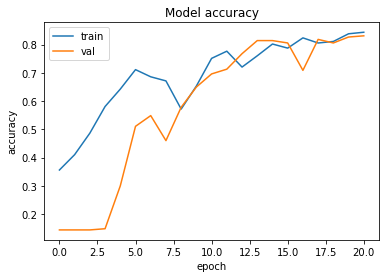

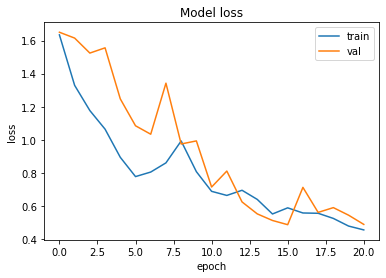

In [9]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('our-accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.savefig('our-loss.png')
plt.show()
